# Esercitazione 11

## Esercizio 2

Definisco la funzione polinomiale da predire:
$$
f(x)=4-3x-2x^2+3x^3
$$

Nel generare i dati con rumore stocastico, pongo $\sigma = 0.8$. Genero due serie di dati di validazione: la prima cade nell'intervallo usato per il training, ovvero $[-1,1]$ la seconda invece copre  l'intervallo successivo: $[1,3]$. Valuterò poi se il modello ha un comportamento peggiore nel secondo caso.

In [2]:
import numpy as np

def polynomial (x):
    a = 4 
    b = -3
    c = -2 
    d = 3
    return a + b*x +c*x**2 + d*x**3

np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid1 = np.random.uniform(-1, 1, 100)
x_valid2 = np.random.uniform(1, 2, 100)
x_valid1.sort()
x_valid2.sort()
y_target1 = polynomial(x_valid1)
y_target2 = polynomial(x_valid2)

sigma = 0.8 # noise standard deviation, 
y_train = np.random.normal(polynomial(x_train), sigma) 
y_valid1 = np.random.normal(polynomial(x_valid1), sigma)
y_valid2 = np.random.normal(polynomial(x_valid2), sigma)

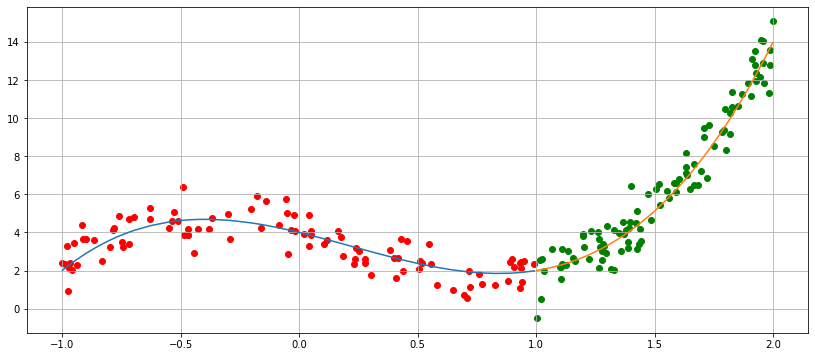

In [3]:
# plot training and target dataset
import matplotlib.pyplot as plt

plt.figure(figsize = (14,6))
plt.plot(x_valid1, y_target1)
plt.scatter(x_valid1, y_valid1, color='r')
plt.plot(x_valid2, y_target2)
plt.scatter(x_valid2, y_valid2, color='g')
plt.grid(True); 
plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt

### N layers

Creo ora la rete neurale. Vario $n_{layers}$ per osservare come varia il fit, tenendo però tale numero limitato a poche unità, in quanto la funzione in esame è decisamente poco complessa.

Nlayers è:  1
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 2ms/step - loss: 1.2801 - mse: 1.2801
Performance dei dati di validazione:
Test loss: 1.28
Test accuracy: 1.28


ValueError: x and y must be the same size

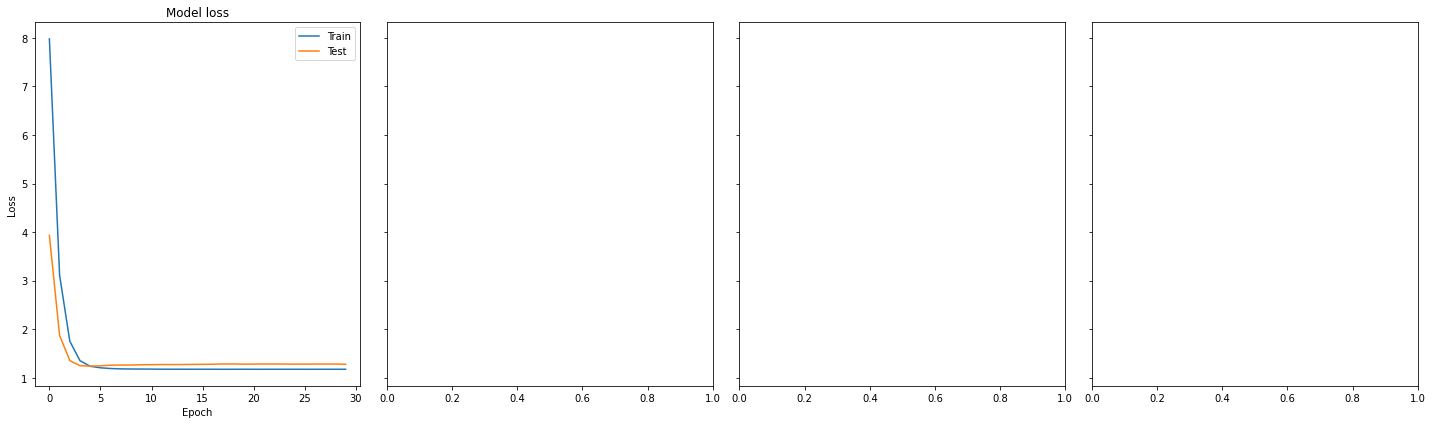

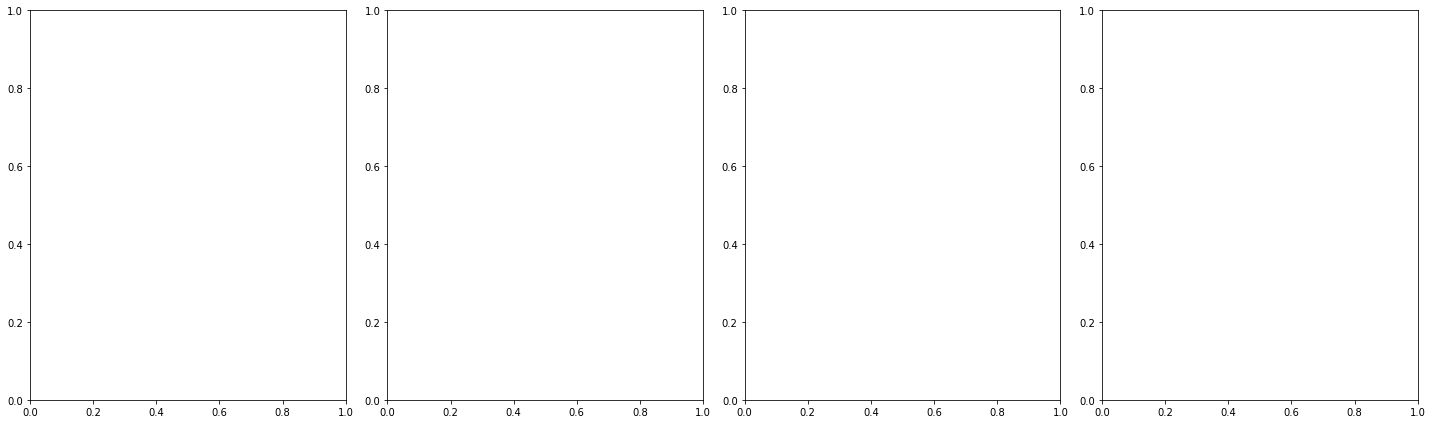

In [55]:
fig_loss, ax = plt.subplots(1, 4, figsize=(20, 6), tight_layout=True, sharey= True)
fig_fit, axs = plt.subplots(1, 4, figsize=(20, 6), tight_layout=True)

best_loss = 1e5
best_layers = 0

layers = [1,3,5,10]

for i in range(0,4):
    nlayers = layers[i]
    print ('Nlayers è: ', nlayers)
    model = tf.keras.Sequential()
    model.add(Dense(nlayers, input_shape=(1,))) 
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    model.summary()

    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=30,
              shuffle=True, # a good idea is to shuffle input before each epoch
              validation_data=(x_valid1, y_valid1),
              verbose = 0)
    model.get_weights()
    score = model.evaluate(x_valid1, y_valid1, batch_size=32, verbose=1)

    print("Performance dei dati di validazione:")
    print('Test loss: %.2f' %score[0])
    print('Test accuracy: %.2f' %score[1])
    
    # look into training history
    # Plot training & validation loss values
    ax[i].plot(history.history['loss'])
    ax[i].plot(history.history['val_loss'])
    ax[i].set_title('Model loss')
    ax[i].set_ylabel('Loss')
    ax[i].set_xlabel('Epoch')
    ax[i].legend(['Train', 'Test'], loc='best')
    
    x_predicted = np.random.uniform(-1, 1, 100)
    y_predicted = model.predict(x_train)
    #print ('lenght are', x_predicted.shape, y_predicted.shape)
    #print ('lenght are', x_predicted.shape, y_predicted.shape)
    axs[i].scatter(x_predicted, y_predicted,color='r')
    axs[i].plot(x_valid1, y_target1)
    axs[i].grid(True)
    #del (model, y_predicted, history)

Osservo che all'aumentare del numero di layers la loss function aumenta.

### Exercise 11.2


In order to make practice with NN, explore reasonable different choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Make graphs comparing fits for different NNs.
Check your NN models by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

Ideas to meditate on these exercises and judge your results can be found <a href=https://xkcd.com/2048/>here</a>

### <span style="color:green">Supplementary material: Keras model.fit available callbacks</span>

The .fit method can also get <a href=https://keras.io/callbacks/>callback</a> functions which can be used to customize the fitting procedure with special actions.

Keras provides some predefined callbacks to feed in, among them for example:
- **TerminateOnNaN()**: that terminates training when a NaN loss is encountered
- **ModelCheckpoint(filepath)**: that save the model after every epoch
- **EarlyStopping()**: which stop training when a monitored quantity has stopped improving

You can select one or more callback and pass them as a list to the callback argument of the fit method.

Now we are going to construct a callback object to represent how estimated parameters are converging during the training procedure

In [12]:
from IPython.display import clear_output

class PlotCurrentEstimate(tf.keras.callbacks.Callback):
    def __init__(self, x_valid, y_valid):
        """Keras Callback which plot current model estimate against reference target"""
        
        # convert numpy arrays into lists for plotting purposes
        self.x_valid = list(x_valid[:])
        self.y_valid = list(y_valid[:])
        self.iter=0

    def on_epoch_end(self, epoch, logs={}):
        
        temp = self.model.predict(self.x_valid, batch_size=None, verbose=False, steps=None)
        self.y_curr = list(temp[:]) # convert numpy array into list
        
        self.iter+=1
        if self.iter%10 == 0:
            clear_output(wait=True)            
            self.eplot = plt.subplot(1,1,1)
            self.eplot.clear()     
            self.eplot.scatter(self.x_valid, self.y_curr, color="blue", s=4, marker="o", label="estimate")
            self.eplot.scatter(self.x_valid, self.y_valid, color="red", s=4, marker="x", label="valid")
            self.eplot.legend()

            plt.show()

We will use also an EarlyStopping callback on the val_loss quantity. This will stop the training process as soon as the val_loss quantity does not improve anymore after an amount of epochs, preventing a long time of wated computation to take over without useful results.

<code>keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)</code>

Arguments:

- <code>monitor</code>: quantity to be monitored. 
- <code>min_delta:</code> minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement. 
- <code>patience:</code> number of epochs with no improvement after which training will be stopped. 
- <code>verbose:</code> verbosity mode. 
- <code>mode:</code> one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity. 
- <code>baseline:</code> Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show improvement over the baseline. 
- <code>restore_best_weights:</code> whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

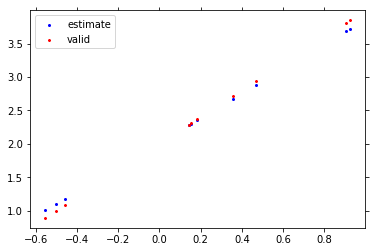

[array([[1.8340337]], dtype=float32), array([2.0234365], dtype=float32)]

In [13]:
plot_estimate = PlotCurrentEstimate(x_valid, y_valid)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=100, mode='auto')

model.fit(x_valid, y_valid, batch_size=32, epochs=150,
          validation_data=(x_valid, y_valid),
          callbacks=[ plot_estimate, earlystop]
          )

model.get_weights()